In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from glob import glob
import safep
import matplotlib as mpl
mpl.rc('xtick', labelsize=20)
mpl.rc('ytick', labelsize=20)

import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import re

import warnings #Suppress future warnings from pandas.
warnings.simplefilter(action='ignore', category=FutureWarning)

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


# What this Notebook Does:

Each section of this notebook will calculate a component of the free energy of binding of phenol to lysozyme as described in the companion tutorial. Briefly, during a free energy perturbation simulation, NAMD (or other software) will write the difference in internal energy between the simulated state and an adjacent state (dE =  E_lambda_k+/-1 - E_lambda_k, where lambda_k determines the ensemble being simulated). The functions used by this notebook read, parse, and process those outputs into a standard format that can be quickly analyzed using one of several methods. By default, we use the Bennett Acceptance Ratio (BAR) estimator with automated decorrelation to make the calculations more robust to both outliers and autocorrelation. See Shirts and Chodera (2018) for more details.

One section of the notebook uses [thermodynamic integration (TI)](https://en.wikipedia.org/wiki/Thermodynamic_integration) to calculate the free energy cost of imposing the DBC restraint. This calculation is much more straightforward than FEP calculations. We can analytically determine the derivative of the force with respect to lambda over a series of simulations at discrete values of lambda. Averaging and accumulating those derivatives yields the free energy cost.

# How to Use this Notebook:

## User Parameters:
The notebook as-is will read and process the sample outputs provided. 
To use it for your own data, be sure to update the section labeled "User Settings" below. Pay special attention to the *root* and *path* variables.

- root should be the path (relative or absolute) to the parent directory that contains (or will containt) all your data.
- temperature is the temperature **at which your simulations were run** 
- decorrelate is a flag for automatic decorrelation of samples (see Shirts and Chodera '08). Should be set to True for general use. 
- detectEQ (automatic equilibrium detection). Set to True. This is more robust than manually guessing at the time required for equilibration prior to a FEP run.

## Layout:
The notebook is organized into five sections (separated by horizontal lines):
- Process the Bound Data [(step B)](#bound_fep)
- Process the DBC TI calculation [(step C)](#DBC_TI)
- Process the Unbound Data [(step D)](#unbound_fep)
- Calculate the Volumetric Restraint Contribution [(step E.2)](#volume)
- Calculate the Binding Free Energy [(step E.3)](#total)

## File Structure Data:

```
Repository/Supp-Files
|
|----stepB_alchemy_site
|    |----[sample_]output
|         | *.fepout
|
|----stepC_restraint_perturbation
|    |----[sample_]output
|         | *.colvars.traj
|
|----stepD_alchemy_bulk
|    |----[sample_]output
|         | *fepout
|
|
```



# Other Important Notes and Credits
- This notebook is specially written for the SAFEP tutorial. 
For more up-to-date and general versions see the SAFEP github.

- This and other SAFEP notebooks make use of pyMBAR and Alchemlyb. 
For more information see Shirts and Chodera (2008), ["Statistically optimal analysis of samples from multiple equilibrium states"](https://doi.org/10.1063%2F1.2978177)



# User Settings:

In [2]:
root = '.' # Root path to fepout files

# Used throughout
temperature = 300
R = sp.constants.R/(1000*sp.constants.calorie) # gas constant in kcal/(mol K)
RT = R * temperature # RT in kcal/mol

## Colvar Settings

In [3]:
def get_num_regex(regex, fname, grp=2):
    with open(fname) as fin:
        fstring = fin.read()
        return re.search(regex, fstring).group(grp)
    
# Used in restraint perturbation calculations
colvarregex = '(upperWalls[\ \t]+)(\d+.\d+)'

# Radius of the spherical restraint used for the DBC TI calculation
COMfname = f'{root}/stepC_restraint_perturbation/sample_outputs/DBC_restraint_RFEP.colvars'
COMradius = float(get_num_regex(colvarregex, COMfname)) 

# Position of the DBC upper wall
DBCfname = f'{root}/stepC_restraint_perturbation/inputs/run.namd'
DBCwidth = float(get_num_regex(colvarregex, DBCfname))  

## Update these paths to point to your output files:

In [4]:
bound_fep_path=f'{root}/stepB_alchemy_site/sample_outputs/' 
restraint_perturbation_path = f'{root}/stepC_restraint_perturbation/sample_outputs/'
bulk_fep_path=f'{root}/stepD_alchemy_bulk/sample_outputs/'

## Advanced settings:

In [5]:
detectEQ = True #Flag for automatic equilibrium detection and decorrelation

***
<a id='bound_fep'></a>
# Process the Bound FEP Data 
Here we process the FEP data generated by decoupling the ligand from the protein (**Step B**)


In [7]:
filename='*.fepout' #This can be a regex pattern if you have more than one fepout file
#Caution: if you have multiple fepout files, name them alphanumerically

fepoutFiles = glob(bound_fep_path+filename) #Resolve any naming regular expressions
u_nk = safep.read_and_process(fepoutFiles, temperature, decorrelate=None, detectEQ=detectEQ) #u_nk stores the fep data
perWindow, cumulative = safep.do_estimation(u_nk) #Run the BAR estimator on the fep data
forward, forward_error, backward, backward_error = safep.do_convergence(u_nk) #Used later in the convergence plot

dG_site = np.round(cumulative.BAR.f.iloc[-1]*RT, 1)
error_site = np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)
#\u0394 == Delta
change_mkd = f'\u0394G<sub>site</sub> = {dG_site} kcal/mol'
error_mkd = f'PyMBAR estimated error: {error_site} kcal/mol'
Markdown('<font size=5>{}</font><br/><font size=5>{}</font><br/>'.format(change_mkd, error_mkd))

Detecting Equilibrium (includes decorrelating)


<font size=5>ΔG<sub>site</sub> = 14.5 kcal/mol</font><br/><font size=5>PyMBAR estimated error: 0.0 kcal/mol</font><br/>

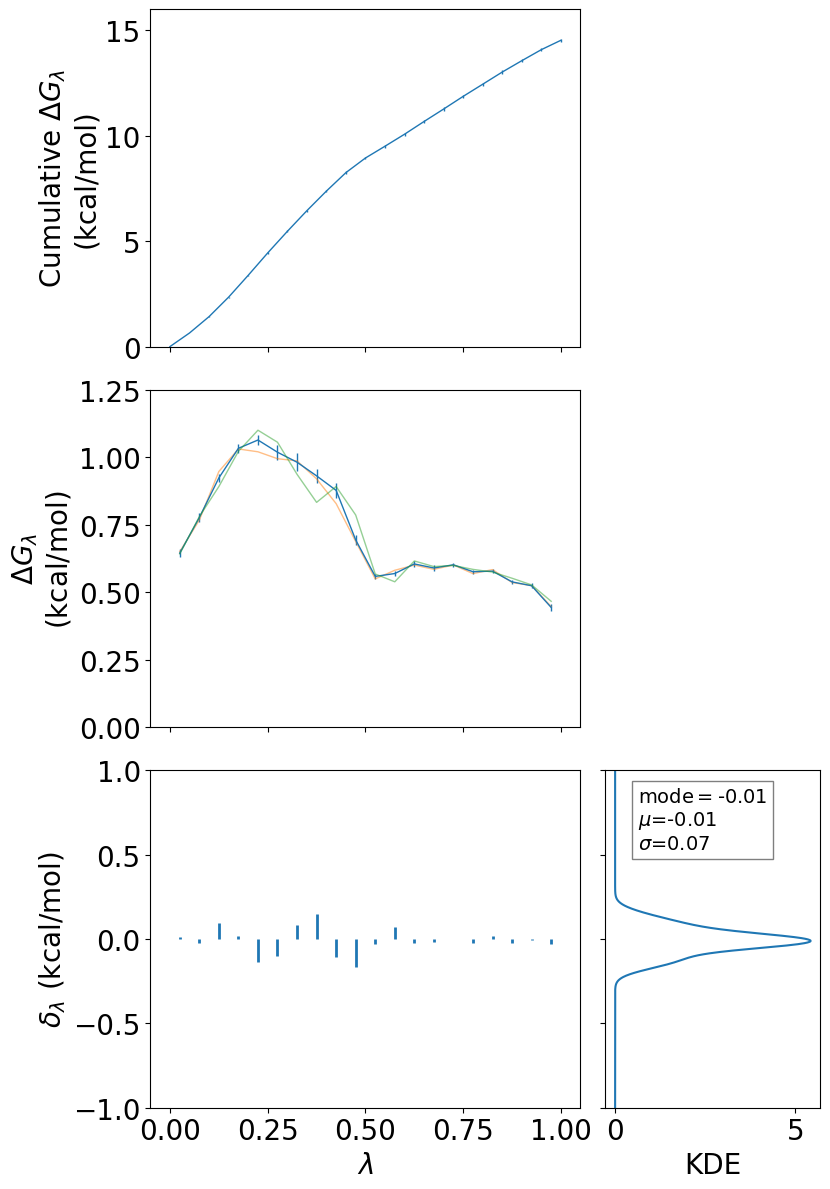

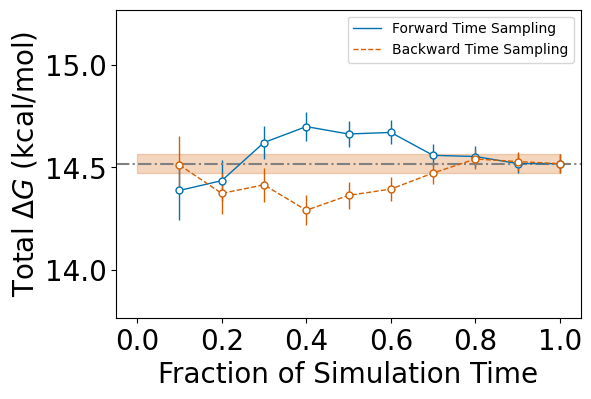

In [22]:
#Make some general plots
width = 8
height = 4
fig, axes = safep.plot_general(
    cumulative, 
    (0,16), 
    perWindow, 
    (0,1.25), 
    RT, 
    width=width, 
    height=height, 
    PDFtype='KDE', 
    fontsize=20)
plt.savefig(f'{bound_fep_path}/bound_generalFigures.pdf', bbox_inches="tight")
plt.show()

fig, convAx = plt.subplots(1,1)
convAx = safep.convergence_plot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT, fontsize=20)

fig.set_figwidth(width*3/4)
fig.set_figheight(height)

plt.savefig(f'{bound_fep_path}/bound_convergence.pdf', bbox_inches="tight")
plt.show()

***
<a id='DBC_TI'></a>
# Process the DBC TI calculation
Compute the free energy cost of restraining the DBC coordinate (**Step C**)

Note: The error estimate below is just the standard deviation of the samples. <br>
The BAR errors calculated above are standard errors of the mean.

In [ ]:
# Setup and processing of colvars data
colvarsPath = glob(restraint_perturbation_path+'*.colvars.traj')[0]
with open(colvarsPath) as f:
    first_line = f.readline()
columns = re.split(' +', first_line)[1:-1]
dataTI = pd.read_csv(colvarsPath, delim_whitespace=True, names=columns, comment='#', index_col=0)
dataTI = dataTI[dataTI.index>=1000][1:]
dataTI.index = dataTI.index-1000

nLambdas = 41
Lsched = np.linspace(1,0,nLambdas)

Dist = safep.make_harmonicWall(FC=200, upperWalls=COMradius, name='Dist_rest')
DBC = safep.make_harmonicWall(FC=0, targetFC=200, targetFE=6, upperWalls=DBCwidth, targetEQ=500, numSteps=300000, name='DBC_rest', schedule=Lsched)
Ls = (dataTI.index.values-1)//DBC['numSteps']
Ls[0] = 0
Ls[Ls==41] = 40 # This is a small hack in case there are extra samples for the last windowj

dataLs = np.round([DBC['schedule'][i] for i in Ls], 3)
dataTI.loc[:,'L'] = dataLs
dataTI = dataTI.iloc[1:]

TIperWindow, TIcumulative = safep.process_TI(dataTI, DBC, Lsched)

In [ ]:
dG_DBC = np.round(TIcumulative['dG'][1], 1)
error_DBC = np.round(TIcumulative['error'][1], 1)
change_mkd = f'\u0394G<sub>DBC</sub> = {dG_DBC} kcal/mol'
error_mkd = f'Standard Deviation: {error_DBC} kcal/mol'
Markdown('<font size=5>{}</font><br/><font size=5>{}</font><br/>'.format(change_mkd, error_mkd))

In [ ]:
''' Plot the results. '''
fig, axes = safep.plot_TI(TIcumulative, TIperWindow, fontsize=20)
plt.savefig(f'{restraint_perturbation_path}/TI_general.pdf', bbox_inches="tight")
plt.show()

***
<a id='unbound_fep'></a>
# Process the Bulk FEP Data
Ligand decoupling from solvent (**Step D**)

In [ ]:
filename='*.fepout' #This can be a regex pattern if you have more than one fepout file
fepoutFiles = glob(bulk_fep_path+filename) #Resolve any naming regular expressions
u_nk = safep.read_and_process(fepoutFiles, temperature, True, detectEQ) #u_nk stores the fep data
perWindow, cumulative = safep.do_estimation(u_nk) #Run the BAR estimator on the fep data
forward, forward_error, backward, backward_error = safep.do_convergence(u_nk) #Used later in the convergence plot

dG_bulk = np.round(cumulative.BAR.f.iloc[-1]*RT, 1)
error_bulk = np.round(cumulative.BAR.errors.iloc[-1]*RT, 1)
change_mkd = f'\u0394G<sub>bulk</sub> = {dG_bulk} kcal/mol'
error_mkd = f'PyMBAR estimated error: {error_bulk} kcal/mol'
Markdown('<font size=5>{}</font><br/><font size=5>{}</font><br/>'.format(change_mkd, error_mkd))

In [ ]:
width = 8
height = 4

fig, axes = safep.plot_general(cumulative, (0,8), perWindow, (-0.5,1), RT, width=width, height=height, PDFtype='KDE', fontsize=20)
plt.savefig(f'{bulk_fep_path}bulk_generalFigures.pdf', bbox_inches="tight")
plt.show()

fig, convAx = plt.subplots(1,1)
convAx = safep.convergence_plot(convAx, forward*RT, forward_error*RT, backward*RT, backward_error*RT, fontsize=20)
convAx.set(xlabel='Fraction of Simulation Time', ylabel=r'Total $\rm\Delta G_{\lambda}$ (kcal/mol)')
fig.set_figwidth(width*3/4)
fig.set_figheight(height)
convAx.legend()
plt.savefig(f'{bulk_fep_path}bulk_convergence.pdf', bbox_inches="tight")
plt.show()

***
<a id='volume'></a>
# Calculate the Volumetric Restraint Contribution
**Step E.2**


In [ ]:
molar = 1660 #cubic angstroms per particle in a one molar solution
dG_V = np.round(-RT*np.log(4/3*sp.pi*COMradius**3/molar), 1)
error_V = 0

In [ ]:
change_mkd = f'\u0394G<sub>V</sub> = {np.round(dG_V, 1)} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(change_mkd))

***
<a id='total'></a>
# Calculate the Binding Free Energy
**Step E.3 to End**

In [ ]:
dG_binding = dG_bulk + dG_V + dG_DBC - dG_site
error_binding = np.sqrt(np.sum(np.array([error_bulk, error_V, error_site, error_DBC])**2))

In [ ]:
changeAndError = f'\u0394G<sub>bind</sub> = {np.round(dG_binding, 1)}\u00B1{np.round(error_binding, 1)} kcal/mol'
Markdown('<font size=5>{}</font><br/>'.format(changeAndError))

# Estimate the titration curve

In [ ]:
def P_bind(K, L):
    return L/(K+L)

def Kd(dG, RT):
    return np.exp(dG/RT)*1000000

In [ ]:
concentrations = np.logspace(0,5,1000) # A vector of concentrations in micromolar
K = Kd(dG_binding, RT)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(concentrations, P_bind(K, concentrations), label='Binding Curve')
ax.fill_between(concentrations, P_bind(Kd(dG_binding-error_binding*1.96, RT), concentrations), P_bind(Kd(dG_binding+error_binding*1.96, RT), concentrations), alpha=0.25, label='95% Confidence Interval')
plt.xscale('log')
ax.set_xlabel('Concentration of Phenol '+r'($\mathrm{\mu}$M)', fontsize=20)
ax.set_ylabel('Fraction of Sites Occupied', fontsize=20)
ax.vlines(K, 0, 1, linestyles='dashed', color='black', label='Dissociation Constant')
ax.legend(loc='lower right', fontsize=20*0.75)

plt.savefig(f'./titration_curve.pdf', bbox_inches="tight")
plt.show()